<a href="https://colab.research.google.com/github/khodid/2020Evening/blob/master/proj3_MNIST_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2020년 하계 프로젝트 \#3
- Evening 스터디 2020 하계 방학 개인 프로젝트 \#3
- 개발 기간: 2020.08.13, 2020.08.20(2일)
- 주제: MNIST data로 VAE 훈련시키기.

지난 프로젝트 1, 2에서 모델 구현까지는 완료했지만 뚜렷한 성과가 없어, 가장 기본 예제인 MNIST를 시도해보기로 하였다.

## 기본적인 설정들
- device 설정
- Dataset 불러오기([torchvision.datasets.MNIST](https://pytorch.org/docs/stable/torchvision/datasets.html#mnist))
 - torchvision.datasets.MNIST(root, train=True, transform=None, target_transform=None, download=False)
- DataLoader 설정


In [1]:
# dataset 다운받기
import torchvision

MNIST_train = torchvision.datasets.MNIST(root = './content', train = True, transform = torchvision.transforms.ToTensor(), download = True)

Extracting ./content/MNIST/raw/train-images-idx3-ubyte.gz to ./content/MNIST/raw



Extracting ./content/MNIST/raw/train-labels-idx1-ubyte.gz to ./content/MNIST/raw


Extracting ./content/MNIST/raw/t10k-images-idx3-ubyte.gz to ./content/MNIST/raw


Extracting ./content/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./content/MNIST/raw
Processing...
Done!




/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [2]:
import torch.utils

In [3]:
# dataloader 설정
batch_size = 20

train_set = torch.utils.data.DataLoader(MNIST_train, batch_size= batch_size, shuffle = True, drop_last = True)

In [4]:
# 디바이스 설정
import torch.cuda
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda' : torch.cuda.manual_seed_all(777)

In [5]:
# Checking training data shape
print(type(train_set))
for img, label in train_set:
  break
print(img.shape)

<class 'torch.utils.data.dataloader.DataLoader'>
torch.Size([20, 1, 28, 28])


## 모델 설계하기
- 모델 선언
- 모델 점검

In [6]:
import torch.nn as nn

class VAE(nn.Module):
  def __init__(self, latent_size):
    super(VAE, self).__init__()
    self.latent_size = latent_size
    self.encoder = nn.Sequential(
                                  # layer 1
                                  nn.Conv2d(1, 16, kernel_size = 5, stride = 1, padding = 2), # 1(28, 28) -> 16(28, 28)
                                  nn.BatchNorm2d(16),
                                  nn.ReLU(),
                                  
                                  #layer 2
                                  nn.Conv2d(16, 32, kernel_size = 5, stride = 2, padding=2), # 16(28, 28) -> 32(14, 14)
                                  nn.BatchNorm2d(32),
                                  nn.ReLU(),

                                  # layer 3
                                  nn. Conv2d(32, 64, kernel_size= 3, stride = 2, padding = 1), # 32(14, 14) -> 32(7, 7)
                                  nn.BatchNorm2d(64),
                                  nn.ReLU(),

                                  # output layer
                                  nn.Flatten()  # 64*7*7 = 3136
    )
    self.fc_mu = nn.Linear(3136, self.latent_size)
    self.fc_logvar = nn.Linear(3136, self.latent_size)
    self.fc_decode = nn.Linear(self.latent_size, 3136)
    self.decoder = nn.Sequential(
                                  # 
                                  # 3-T
                                  nn.ConvTranspose2d(64, 32, kernel_size = 3, stride = 2, padding=1, output_padding=1),
                                  nn.BatchNorm2d(32),
                                  nn.LeakyReLU(),

                                  # 2-T
                                  nn.ConvTranspose2d(32, 16, kernel_size=5, stride=2, padding=2, output_padding=1),
                                  nn.BatchNorm2d(16),
                                  nn.LeakyReLU(),

                                  # 1-T
                                  nn.ConvTranspose2d(16, 1, kernel_size=5, stride=1, padding=2),
                                  nn.Sigmoid()
    )
  def reparameterize(self, mu, var):
    sigma = torch.exp(0.5*var)
    epsilon = torch.randn_like(sigma)
    return mu + sigma * epsilon

  def encode(self, img):
    h = self.encoder(img)
    mu, log_var = self.fc_mu(h), self.fc_logvar(h)
    z = self.reparameterize(mu, log_var)
    return z, mu, log_var

  def decode(self, z):
    z = self.fc_decode(z)
    new_img = self.decoder(z.view(z.size(0), 64, 7, 7))
    return new_img


====== ENCODER ======
torch.Size([64, 10])
====== DECODER ======
torch.Size([64, 1, 28, 28])


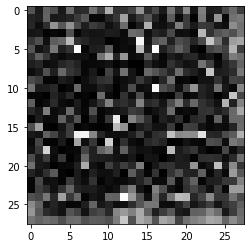

In [7]:
# model test
with torch.no_grad():
  input = torch.randn(64, 1, 28, 28).to(device)
  model = VAE(latent_size = 10).to(device)
  test_z, _, _ = model.encode(input)
  test_out = model.decode(test_z)

  print('====== ENCODER ======')
  print(test_z.shape)
  print('====== DECODER ======')
  print(test_out.shape)

  import matplotlib.pyplot as plt
  if device == 'cuda': test_out = test_out.cpu()
  show = test_out[0].view(28,28).numpy()
  plt.imshow(show, cmap='gray')

## 학습
- optimizer: RMSprop
- cost function: VAE의 cost function 이론로 했음. restruction cost + divergence cost

검증 작업에서 gradient 계산을 제외해야 하기 때문에 model.train() 또는 model.eval()을 적극 확용해야 하는데,
중간점검 이미지 출력부분에서 with torch.no_grad()를 써서 그런지 처음엔 학습이 잘 되다가 아예 막히는 현상 발생함.

[gradient 계산 모드 관련 문서](https://medium.com/jun-devpblog/pytorch-6-model-train-vs-model-eval-no-grad-hyperparameter-tuning-3812c216a3bd)

In [8]:
model = VAE(latent_size= 100).to(device)
model.train()

VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Flatten()
  )
  (fc_mu): Linear(in_features=3136, out_features=100, bias=True)
  (fc_logvar): Linear(in_features=3136, out_features=100, bias=True)
  (fc_decode): Linear(in_features=100, out_features=3136, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_runn

In [9]:
# 얘는 그냥 프로젝트 1에서 복붙함. loss function

def loss_function(x, target, mu, log_var):
  x, target = x.view(-1, 784), target.view(-1, 784) # 안 넣으면 오류남
  # r_loss = torch.sqrt(torch.mean(torch.square(target - x)) + 1e-7) # p98 참고 # 0 되는 걸 방지하기 위해
  r_loss = nn.functional.binary_cross_entropy(x, target, reduction='sum')
  kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
  return r_loss, kl_div, r_loss + kl_div

In [10]:
# 진행상황 모니터링용
def compare_img(img, new_img, label, epoch):
  with torch.no_grad():
    if device == 'cuda': img, new_img = img.cpu(), new_img.cpu()
    show_original = img.view(28,28).numpy()
    show_gen = new_img.view(28,28).numpy()

    plt.subplot(1, 2, 1)
    plt.title('original')
    plt.imshow(show_original, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title('generated')
    plt.imshow(show_gen, cmap = 'gray')
    
    plt.suptitle('Epoch: {} [label-{}]'.format(epoch, label), fontsize=16)
    plt.savefig('MNIST_VAE_train_{}.png'.format(epoch))

    plt.clf() # 다음 그림 위해서 비워두기

In [11]:
optimizer = torch.optim.RMSprop(model.parameters(),lr = 0.002)

In [12]:
lenth = len(train_set)

In [13]:
epochs = 20
tick = [0, 5, 8, 10, 15, 20, 50, 100, 120, 150, 180, 200]

model.train(True)

for epoch in range(epochs):
  for idx, (img, label) in enumerate(train_set):
    img = img.to(device)
    
    z, mu, var = model.encode(img)
    new_img = model.decode(z)
    r, k, loss = loss_function(new_img, img, mu, var)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (idx+1) % 500 is 0 : print('Epoch [{}/{}] Step [{}/{}] loss: {} rmse: {}, kl_div: {}'.format(epoch+1, epochs, idx+1, lenth, loss.item(), r.item(), k.item()))
  if epoch in tick : compare_img(img[0], new_img[0], label[0], epoch)
compare_img(img[0], new_img[0], label[0], epoch)

Epoch [1/20] Step [500/3000] loss: 6208.3671875 rmse: 2964.213623046875, kl_div: 3244.1533203125
Epoch [1/20] Step [1000/3000] loss: 5702.9619140625 rmse: 2947.546142578125, kl_div: 2755.41552734375
Epoch [1/20] Step [1500/3000] loss: 4411.689453125 rmse: 2206.159912109375, kl_div: 2205.52978515625
Epoch [1/20] Step [2000/3000] loss: 4187.44970703125 rmse: 2647.00830078125, kl_div: 1540.4415283203125
Epoch [1/20] Step [2500/3000] loss: 4997.6689453125 rmse: 2517.844482421875, kl_div: 2479.82421875
Epoch [1/20] Step [3000/3000] loss: 4241.69873046875 rmse: 2530.21044921875, kl_div: 1711.48828125
Epoch [2/20] Step [500/3000] loss: 3447.992431640625 rmse: 2102.22412109375, kl_div: 1345.768310546875
Epoch [2/20] Step [1000/3000] loss: 2504.1142578125 rmse: 1906.2796630859375, kl_div: 597.8345947265625
Epoch [2/20] Step [1500/3000] loss: 2499.5771484375 rmse: 1876.47314453125, kl_div: 623.10400390625
Epoch [2/20] Step [2000/3000] loss: 2197.3017578125 rmse: 1671.275634765625, kl_div: 526.02

<Figure size 432x288 with 0 Axes>

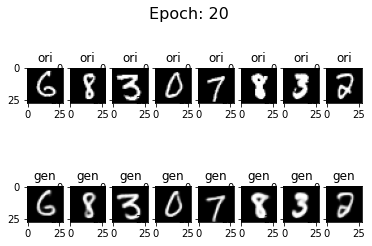

In [18]:
with torch.no_grad():
  # img[0], new_img[0], label[0]
  if device == 'cuda': img, new_img = img.cpu(), new_img.cpu()
  show_original_set = img.view(img.size(0),28, 28).numpy()
  show_gen_set = new_img.view(new_img.size(0), 28, 28).numpy()

  for i in range(8):
    show_original = show_original_set[i]
    show_gen = show_gen_set[i]

    plt.subplot(2, 8, i+1)
    plt.title('ori')
    plt.imshow(show_original, cmap='gray')
    plt.subplot(2, 8, i + 9)
    plt.title('gen')
    plt.imshow(show_gen, cmap = 'gray')
    
  plt.suptitle('Epoch: {}'.format(epoch+1), fontsize=16)

In [26]:
# 랜덤 입력에는 어떻게 반응하는지 궁금해서 넣어보려 했는데 GPU 에러 뜸

with torch.no_grad():
  input = torch.randn(64, 1, 28, 28).to(device)
  z, mu, var = model.encode(input)
  new_img = model.decode(z)

  if device == 'cuda': test_out = test_out.cpu()
  show = test_out[0].view(28,28).numpy()
  plt.imshow(show, cmap='gray')

RuntimeError: ignored